From https://www.tensorflow.org/tutorials/generative/autoencoder

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

Load ECG data

In [5]:
# dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
dataframe = pd.read_csv('ecg.csv', header=None)

In [6]:
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [7]:
# The last element contains the labels
labels = raw_data[:, -1]

In [8]:
# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

Normalize data to [0,1]

In [10]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

Train the autoencoder using only the normal columns, whcih are labelled as "1". Separate normal rhythms from abnormal rhythms.

In [11]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG

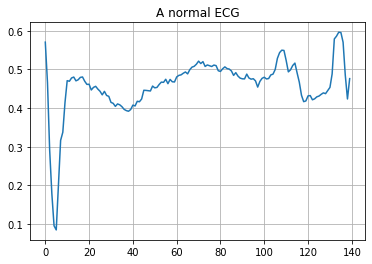

In [12]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A normal ECG")
plt.show()

Plot an anomalous ECG

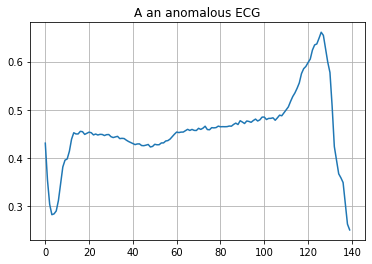

In [13]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("A an anomalous ECG")
plt.show()

Build the model

In [14]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')
        ])
            
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
autoencoder = AnomalyDetector()

In [16]:
autoencoder.compile(optimizer='adam', loss='mae')

Note that encoder is trained using only the normal ECG but is evaluated using the full test set

In [17]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                         epochs=20,
                         batch_size=512,
                         validation_data=(test_data, test_data),
                         shuffle=True)

Train on 2359 samples, validate on 1000 samples
Epoch 1/20
2359/2359 [==============================] - 0s 127us/sample - loss: 0.0576 - val_loss: 0.0531
Epoch 2/20
2359/2359 [==============================] - 0s 7us/sample - loss: 0.0554 - val_loss: 0.0514
Epoch 3/20
2359/2359 [==============================] - 0s 7us/sample - loss: 0.0524 - val_loss: 0.0500
Epoch 4/20
2359/2359 [==============================] - 0s 7us/sample - loss: 0.0491 - val_loss: 0.0484
Epoch 5/20
2359/2359 [==============================] - 0s 8us/sample - loss: 0.0456 - val_loss: 0.0466
Epoch 6/20
2359/2359 [==============================] - 0s 7us/sample - loss: 0.0419 - val_loss: 0.0451
Epoch 7/20
2359/2359 [==============================] - 0s 7us/sample - loss: 0.0385 - val_loss: 0.0434
Epoch 8/20
2359/2359 [==============================] - 0s 7us/sample - loss: 0.0356 - val_loss: 0.0422
Epoch 9/20
2359/2359 [==============================] - 0s 7us/sample - loss: 0.0333 - val_loss: 0.0410
Epoch 10/20
23

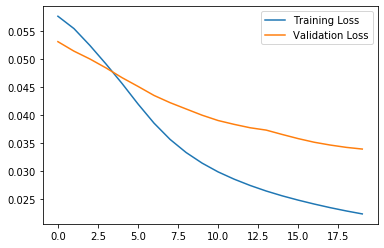

In [18]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

The ECG is classified as anomalous if the reconstruction error is greater than one standard deviation from the normal training samples. First, let's plot a normal ECG from the training set, the reconstruction after it is encoded and decoded by the autoencoder, and the reconstruction error.

In [19]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



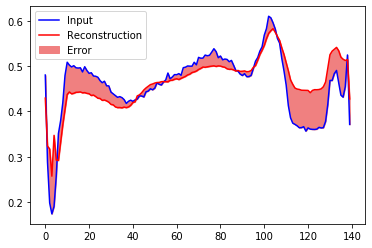

In [20]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Anomalous test sample

In [21]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

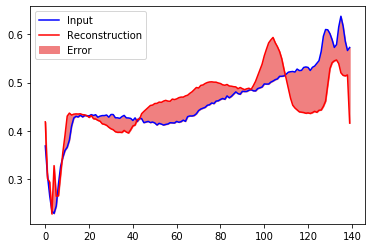

In [22]:
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies
Calculate whether the reconstruction loss is greater than a fixed threshold. Mean average error is used

In [23]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

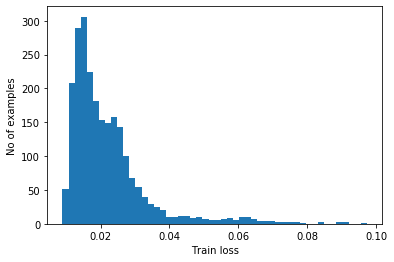

In [24]:
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [25]:
threshold = np.mean(train_loss) + np.std(train_loss)
print(f"Threshold: {threshold}")

Threshold: 0.03360481716359783


Reconstruction error for the anomalous set is greater

In [26]:
reconstructions = autoencoder.predict(anomalous_train_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_train_data)

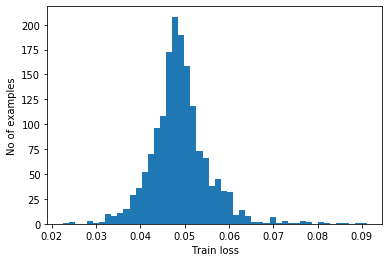

In [27]:
plt.hist(test_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as anomaly if the reconstruction data is greater than the threshold

In [28]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

In [29]:
def print_stats(predictions, labels):
    print(f"Accuracy = {accuracy_score(labels, preds)}")
    print(f"Precision = {precision_score(labels, preds)}")
    print(f"Recall = {recall_score(labels, preds)}")

In [30]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429
